In [329]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from collections import OrderedDict

In [330]:
class Compressor():

    def __init__(self, unbiased):

        self.unbiased = unbiased
        self.contractive = not self.unbiased

    def compress(self, X):

        pass

class TopK(Compressor):

    def __init__(self, K):

        super().__init__(False)
        self.K = K

    def compress(self, X):

        X_compressed = np.zeros_like(X)
        idx = np.abs(X).argsort(axis = 1)[:,-self.K:]
        for k in range(X.shape[0]):
            X_compressed[k, idx[k]] = X[k, idx[k]]
        return X_compressed

class RandK(Compressor):

    def __init__(self, K, shared_randomness=True):

        super().__init__(False)
        self.K = K
        self.share = shared_randomness

    def compress(self, X):

        X_compressed = np.zeros_like(X)
        M = X.shape[1]
        if self.share:
            idx = np.random.randint(0,M,self.K)
            X_compressed[:, idx] = X[:, idx]
        else:
            idx = np.random.randint(0,M, (X.shape[0],self.K))
            X_compressed[idx] = X[idx]
        return X_compressed

class uRandK(Compressor):

    def __init__(self, K, shared_randomness=True):

        super().__init__(True)
        self.K = K
        self.share = shared_randomness

    def compress(self, X):

        X_compressed = np.zeros_like(X)
        M = X.shape[1]
        if self.share:
            # idx = np.random.randint(0,M,self.K)
            idx = np.random.choice(M, self.K, replace=False)
            X_compressed[:, idx] = X[:, idx]
        else:
            # idx = np.random.randint(0,M, (X.shape[0],self.K))
            for k in range(X.shape[0]):
                idx = np.random.choice(M, self.K, replace=False)
                X_compressed[k, idx] = X[k, idx]
            # X_compressed[idx] = X[idx]
        return X_compressed / self.K * M

    def cal_omega(self, M):

        return M / self.K - 1 

class FCC(Compressor):

    def __init__(self, compressor, R):

        super().__init__(compressor.unbiased)
        self.compressor = compressor
        self.R = R
    
    def compress(self, X):

        V = np.zeros_like(X)

        if self.unbiased:

            omega = self.compressor.cal_omega(X.shape[1])
            for r in range(self.R):
                V += self.compressor.compress(X - V) / (1 + omega)
            return V / (1 - (omega / (1 + omega))**self.R)
        
        else:

            for r in range(self.R):
                V += self.compressor.compress(X - V)
            return V
    
    def cal_omega(self, M):

        assert self.unbiased
        omega = self.compressor.cal_omega(M)
        return omega * (omega / (1 + omega))**self.R
    
class NaturalCompression(Compressor):
     
    def __init__(self):
        super().__init__(True)

    def compress(self, X):
        # get mantissa of all entries of numpy array X
        mantissa, exponent = np.frexp(X)
        # get the sign of all entries of numpy array X
        sign = np.sign(X)
        unsigned_mantissa = mantissa * sign
        # calculate the possibility of the Bernoulli experiment
        p = (mantissa * np.sign(X) * 2 - 1).clip(min=0)
        # generate random exponent shift
        shift = np.random.binomial(n=1, p=p, size=X.shape)
        
        return sign * 2.0**(exponent + shift - 1)
        
class RandomQuantization(Compressor):

    def __init__(self, s):
        super().__init__(True)
        self.s = s
        self.llist = [1] + [3] * 2 + [6] * 4 + [7] * 8 + [11] * 16 + [12] * 32 # shifted Elias code
        self.llist = np.array(self.llist)
        self.name = 'RandomQuantization'

    def compress(self, X):
        # calculate the l2 norm of each row
        norm_0 = np.linalg.norm(X, axis=1, keepdims=True)
        norm = norm_0 + (norm_0 == 0) # avoid dividing by zero
        # keep the signs
        signs = np.sign(X)
        X = np.abs(X)
        # calculate the normalized X
        X /= norm
        # print('normalized X:', X)
        # scale X by s
        X *= self.s
        # compute lower bound
        lb = np.floor(X)
        # print('lb:', lb)
        # compute possibility of Bernoulli experiment
        p = X - lb
        # print('p:', p)
        # generate random matrix
        random_matrix = np.random.binomial(n=1, p=p, size=X.shape)
        # compute quantized matrix
        quantized_matrix = lb + random_matrix
        # print('quantized code length:', self.llist[quantized_matrix.astype(int)])
        # print('quantized matrix: ', quantized_matrix)
        # compute the compressed matrix
        compressed_matrix = quantized_matrix * norm_0
        return compressed_matrix * signs / self.s, self.llist[quantized_matrix.astype(int)].sum(axis=1).mean(axis=0) + 64

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


def get_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])

def set_params(model, params):
    param_shapes = [param.data.shape for param in model.parameters()]
    param_sizes = [param.numel() for param in model.parameters()]

    index = 0
    for i, param in enumerate(model.parameters()):
        size = param_sizes[i]
        param_slice = params[index:index + size].view(param_shapes[i])
        param.data.copy_(param_slice)
        index += size


In [ ]:
def split(train_dataset, alpha, num_clients):
    train_size = len(train_dataset)
    subsets = [[] for _ in range(10)]
    final_dataset = [[] for _ in range(num_clients)]
    final_size = train_size // num_clients
    for i in range(train_size):
        image, label = train_dataset[i]
        subsets[label].append((image, label))

    w0 = torch.tensor([1/10 for _ in range(10)])
    dir = dist.Dirichlet(w0*alpha)
    for i in range(num_clients):
        w = dir.sample()
        samples = torch.multinomial(w, final_size, replacement=True)
        for j in range(final_size):
            a = torch.randint(0, len(subsets[samples[j]]), (1,)).item()
            final_dataset[i].append(subsets[samples[j]][a])


    datasets_tensor = []
    for i in range(num_clients):
        images = torch.stack([x[0] for x in final_dataset[i]])
        labels = torch.tensor([x[1] for x in final_dataset[i]], dtype=torch.int64)
        datasets_tensor.append(TensorDataset(images, labels))


    return datasets_tensor

In [ ]:
def client_train(model, train_loader, optimizer, criterion, epochs=1, noise_std=0.01):
    model.train()
    for _ in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            for param in model.parameters():
                noise = torch.randn_like(param.data) * noise_std
                param.data.add_(noise)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_dataset = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
num_clients = 5 
T = 40
num_epochs = 1
theta = 0.9
gamma = 100 
noise_std = 0.01
alpha = 100
u = 2
compressor = TopK(15000)
train_datasets = split(train_dataset, alpha, num_clients)


batch_size = 128
learning_rate = 0.01 

client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

global_model = MLP()
criterion = nn.CrossEntropyLoss()
client_models = [MLP() for _ in range(num_clients)]
client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

In [ ]:
client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

global_model = MLP()
criterion = nn.CrossEntropyLoss()
client_models = [MLP() for _ in range(num_clients)]
client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
client_data_sizes = [len(loader.dataset) for loader in client_loaders]


### Normalized QSGD

In [ ]:
def norm_qsgd(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    print(params1.shape)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]

    accuracy = []

    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)


        m_c = [torch.from_numpy(FCC(compressor,u).compress(mm[i].numpy().reshape(mm[i].size()[0],1))).view(mm[i].size()[0],) for i in range(num_clients)]
        global_params = get_params(global_model)
        sum_tensor = torch.stack([m_c[i] for i in range(num_clients)], 0).sum(0)
        global_params -= gamma * sum_tensor/torch.norm(sum_tensor, p = 2)

        set_params(global_model,global_params)
        for i, client_model in enumerate(client_models):
          set_params(client_model,global_params)

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
            accuracy.append(100 * correct / total)
            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy

### QSGD

In [ ]:
def qsgd(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    print(params1.shape)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]

    accuracy = []

    theta = 0.0
    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
        
        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)


        m_c = [torch.from_numpy(FCC(compressor,u).compress(mm[i].numpy().reshape(mm[i].size()[0],1))).view(mm[i].size()[0],) for i in range(num_clients)]
        global_params = get_params(global_model)
        sum_tensor = torch.stack([m_c[i] for i in range(num_clients)], 0).sum(0)
        global_params -= gamma * sum_tensor/num_clients

        set_params(global_model,global_params)
        for i, client_model in enumerate(client_models):
          set_params(client_model,global_params)

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
            accuracy.append(100 * correct / total)
            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy

### MEM-SGD

In [ ]:
def memsgd(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    print(params1.shape)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]

    theta = 0.0
    accuracy = []
    error = [torch.zeros_like(params1) for _ in range(num_clients)]

    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)


        m_c = [torch.from_numpy(FCC(compressor,u).compress((gamma*mm[i]+error[i]).numpy().reshape(mm[i].size()[0],1))).view(mm[i].size()[0],) for i in range(num_clients)]
        global_params = get_params(global_model)
        sum_tensor = torch.stack([m_c[i] for i in range(num_clients)], 0).sum(0)
        global_params -= sum_tensor/num_clients
        error = [error[i]+gamma*mm[i]-m_c[i] for i in range(num_clients)]

        set_params(global_model,global_params)
        for i, client_model in enumerate(client_models):
          set_params(client_model,global_params)

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
            accuracy.append(100 * correct / total)
            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy

### EF21-SGD


In [ ]:
def ef21sgd(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    print(params1.shape)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]
    M = params1.size()[0]
    theta = 0.0

    accuracy = []

    G_old = [torch.zeros_like(params1) for _ in range(num_clients)]

    
    g_old = torch.stack([G_old[i] for i in range(num_clients)], 0).sum(0)

    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2

        global_params = get_params(global_model)
        global_params -= gamma * g_old/num_clients

        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)


        m_c = [torch.from_numpy(FCC(compressor,u).compress((mm[i]-G_old[i]).numpy().reshape(mm[i].size()[0],1))).view(mm[i].size()[0],) for i in range(num_clients)]

        G_old = [G_old[i]+m_c[i] for i in range(num_clients)]
        g_old = torch.stack([G_old[i] for i in range(num_clients)], 0).sum(0)

        set_params(global_model,global_params)
        for i, client_model in enumerate(client_models):
          set_params(client_model,global_params)

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
            accuracy.append(100 * correct / total)
            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy

In [341]:
gamma = 500
gamma2 = 0.2
accuracy_qsgd = qsgd(gamma2)
accuracy_ef21sgd = ef21sgd(gamma2)
accuracy_memsgd = memsgd(gamma2)
accuracy_normsgd = norm_qsgd(gamma)


torch.Size([109386])
0
1
Step 2: loss = 733.25048828125, Accuracy of the network on the 10000 test images: 6.87 %
2
3
Step 4: loss = 40.15653610229492, Accuracy of the network on the 10000 test images: 12.2 %
4
5
Step 6: loss = 2.316654920578003, Accuracy of the network on the 10000 test images: 9.59 %
6
7
Step 8: loss = 2.2747645378112793, Accuracy of the network on the 10000 test images: 10.12 %
8
9
Step 10: loss = 2.286829948425293, Accuracy of the network on the 10000 test images: 9.6 %
10
11
Step 12: loss = 2.292682409286499, Accuracy of the network on the 10000 test images: 9.58 %
12
13
Step 14: loss = 2.309725284576416, Accuracy of the network on the 10000 test images: 8.92 %
14
15
Step 16: loss = 2.294909954071045, Accuracy of the network on the 10000 test images: 8.91 %
16
17
Step 18: loss = 2.3078112602233887, Accuracy of the network on the 10000 test images: 8.92 %
18
19
Step 20: loss = 2.3125431537628174, Accuracy of the network on the 10000 test images: 8.92 %
20
21
Step 2

In [ ]:
gammas = [200,100,50,20,10,5,2,1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001]
for gamma in gammas2:
    print(gamma)
    accuracy_qsgd_new = qsgd(gamma)
    accuracy_ef21sgd_new = ef21sgd(gamma)
    accuracy_memsgd_new = memsgd(gamma)
    
    if accuracy_qsgd_new[-1] >= accuracy_qsgd[-1]:
        accuracy_qsgd = accuracy_qsgd_new
    if accuracy_ef21sgd_new[-1] >= accuracy_ef21sgd[-1]:
        accuracy_ef21sgd = accuracy_ef21sgd_new
    if accuracy_memsgd_new[-1] >= accuracy_memsgd[-1]:
        accuracy_memsgd = accuracy_memsgd_new

In [ ]:
num_clients = 5 
T = 40
num_epochs = 1
theta = 0.9
gamma = 100 
noise_std = 0.01
alpha = 100
u = 2
compressor = TopK(15000)
train_datasets = split(train_dataset, alpha, num_clients)


batch_size = 128
learning_rate = 0.01 

client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

global_model = MLP()
criterion = nn.CrossEntropyLoss()
client_models = [MLP() for _ in range(num_clients)]
client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

In [342]:
gammas = [0.1,0.05,0.02,0.01,0.005,0.002]
for gamma in gammas:
    print(gamma)
    accuracy_qsgd_new = qsgd(gamma)
    if accuracy_qsgd_new[-1] >= accuracy_qsgd[-1]:
        accuracy_qsgd = accuracy_qsgd_new

0.1
torch.Size([109386])
0
1
Step 2: loss = 23.57125473022461, Accuracy of the network on the 10000 test images: 30.12 %
2
3
Step 4: loss = 2.4664666652679443, Accuracy of the network on the 10000 test images: 13.1 %
4
5
Step 6: loss = 2.266747236251831, Accuracy of the network on the 10000 test images: 12.33 %
6
7
Step 8: loss = 2.1097443103790283, Accuracy of the network on the 10000 test images: 15.55 %
8
9
Step 10: loss = 2.135268211364746, Accuracy of the network on the 10000 test images: 14.73 %
10
11
Step 12: loss = 2.1291658878326416, Accuracy of the network on the 10000 test images: 14.6 %
12
13
Step 14: loss = 2.124025821685791, Accuracy of the network on the 10000 test images: 15.79 %
14
15
Step 16: loss = 2.1120336055755615, Accuracy of the network on the 10000 test images: 15.61 %
16
17
Step 18: loss = 2.114321231842041, Accuracy of the network on the 10000 test images: 15.7 %
18
19
Step 20: loss = 2.117713689804077, Accuracy of the network on the 10000 test images: 14.65 

In [343]:
accuracy_ef21sgd = ef21sgd(0.05)
gammas = [0.02,0.01,0.005,0.002]
for gamma in gammas:
    print(gamma)
    accuracy_ef21sgd_new = ef21sgd(gamma)
    
    if accuracy_ef21sgd_new[-1] >= accuracy_ef21sgd[-1]:
        accuracy_ef21sgd = accuracy_ef21sgd_new

torch.Size([109386])
0
1
Step 2: loss = 2.927170753479004, Accuracy of the network on the 10000 test images: 20.03 %
2
3
Step 4: loss = 6.377597808837891, Accuracy of the network on the 10000 test images: 28.1 %
4
5
Step 6: loss = 8.034897804260254, Accuracy of the network on the 10000 test images: 30.64 %
6
7
Step 8: loss = 3.1261823177337646, Accuracy of the network on the 10000 test images: 46.0 %
8
9
Step 10: loss = 2.4904024600982666, Accuracy of the network on the 10000 test images: 53.64 %
10
11
Step 12: loss = 1.8849234580993652, Accuracy of the network on the 10000 test images: 67.62 %
12
13
Step 14: loss = 0.7857453227043152, Accuracy of the network on the 10000 test images: 74.0 %
14
15
Step 16: loss = 0.7152271866798401, Accuracy of the network on the 10000 test images: 78.99 %
16
17
Step 18: loss = 0.7787235379219055, Accuracy of the network on the 10000 test images: 81.0 %
18
19
Step 20: loss = 0.6823795437812805, Accuracy of the network on the 10000 test images: 81.97 %


In [353]:
accuracy_memsgd = memsgd(0.05)
gammas = [0.02,0.01,0.005,0.002]
for gamma in gammas:
    print(gamma)
    accuracy_memsgd_new = memsgd(gamma)
    
    if accuracy_memsgd_new[-1] >= accuracy_memsgd[-1]:
        accuracy_memsgd = accuracy_memsgd_new

torch.Size([109386])
0
1
Step 2: loss = 2.3047072887420654, Accuracy of the network on the 10000 test images: 55.36 %
2
3
Step 4: loss = 3.2341134548187256, Accuracy of the network on the 10000 test images: 54.08 %
4
5
Step 6: loss = 0.2838760018348694, Accuracy of the network on the 10000 test images: 75.19 %
6
7
Step 8: loss = 0.053867824375629425, Accuracy of the network on the 10000 test images: 79.09 %
8
9
Step 10: loss = 0.29881665110588074, Accuracy of the network on the 10000 test images: 78.74 %
10
11
Step 12: loss = 0.2722638249397278, Accuracy of the network on the 10000 test images: 80.0 %
12
13
Step 14: loss = 0.2482735812664032, Accuracy of the network on the 10000 test images: 81.55 %
14
15
Step 16: loss = 0.24046698212623596, Accuracy of the network on the 10000 test images: 82.53 %
16
17
Step 18: loss = 0.25444296002388, Accuracy of the network on the 10000 test images: 82.76 %
18
19
Step 20: loss = 0.2083386927843094, Accuracy of the network on the 10000 test images: 

In [ ]:
accuracy_normsgd = norm_qsgd(200)
gammas2 = [100,50,20]
for gamma in gammas2:
    print(gamma)
    accuracy_normsgd_new = norm_qsgd(gamma)
    if accuracy_normsgd_new[-1] >= accuracy_normsgd[-1]:
        accuracy_normsgd = accuracy_normsgd_new 

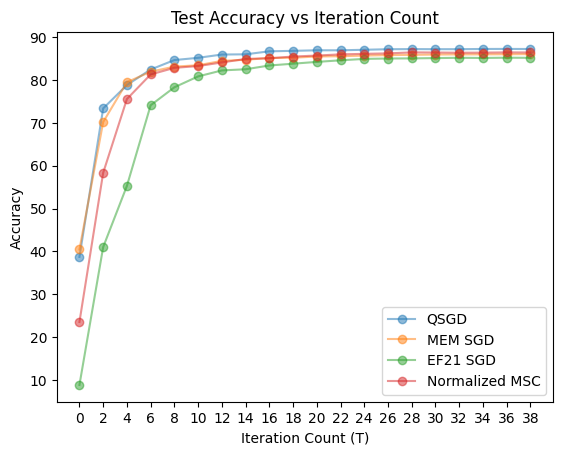

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


T = np.arange(0, 40, 2)

plt.plot(T, accuracy_qsgd, '-o', label='QSGD', alpha=0.5)
plt.plot(T, accuracy_memsgd, '-o', label='MEM SGD', alpha=0.5)
plt.plot(T, accuracy_ef21sgd, '-o', label='EF21 SGD', alpha=0.5)
plt.plot(T, accuracy_normsgd, '-o', label='Normalized MSC', alpha=0.5)

plt.xticks(T)

plt.title('Test Accuracy vs Iteration Count')
plt.xlabel('Iteration Count (T)')
plt.ylabel('Accuracy')

plt.legend()

plt.show()